# Generator

Predict water_level

In [1]:
from pandas import read_csv
from matplotlib import pyplot
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras import Model

from keras.models import Sequential
from keras.layers import Dense, Input, Attention
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import *
from keras.models import *
from keras import backend as K

from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor


In [5]:
#load data
def load_data():
    dataset = read_csv('yaupon.csv', header=0, usecols = [2], engine='python')
    # dataset = read_csv('data_myrtle.csv', header=0, usecols = [2], engine='python')

    dataset[:] = numpy.nan_to_num(dataset)    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    return scaler, dataset


      Waterlevel(ft)
0               3.59
1               3.57
2               3.55
3               3.52
4               3.50
...              ...
5379            4.79
5380            4.86
5381            5.15
5382            5.02
5383            4.92

[5384 rows x 1 columns]


In [3]:
def create_dataset(dataset, look_back=1, look_ahead=0):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back - look_ahead-1):
		a = dataset[i:(i+look_back), 0]
        
		dataX.append(a)
		dataY.append(dataset[i + look_back + look_ahead, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
def make_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(16, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(8, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mse', optimizer='adam') 
    model.summary()
    return model

def fit_generator(model, trainX, trainY, testY):  
    model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    traingen = trainPredict
    testgen = testPredict

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    gen_testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    return trainPredict, gen_testPredict, testY, trainY


In [5]:
# make predictions
def gen_results(trainY, testY, trainPredict, gen_testPredict):
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#     print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], gen_testPredict[:,0]))
#     print('Test Score: %.2f RMSE' % (testScore))
    
    return testScore
# trainScore = math.sqrt(r2_score(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f R2' % (trainScore))
# testScore = math.sqrt(r2_score(testY[0], testPredict[:,0]))
# print('Test Score: %.2f R2' % (testScore))


In [6]:
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back * 2) + (look_ahead*2) + 1:len(dataset)-1, :] = gen_testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

# Discriminator



In [7]:
# need to run first two cells to reset the dataset

def init_discriminator(dataset, trainX, trainY, testY):
    dataset = scaler.inverse_transform(dataset)
#     print(trainX)
    trainY = dataset[1 : train_size - 1 - look_ahead] - trainPredict[:]
    testY = dataset[train_size + look_ahead: - 2] - gen_testPredict[:]

    trainY = scaler.fit_transform(trainY)
    testY = scaler.fit_transform(testY)
    return dataset, trainX, trainY, testY
#     print(testY)
    


In [8]:
def fit_discriminator(disc_model, trainX, textX, trainY, testY):

    disc_model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    disc_testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    return disc_testPredict, trainPredict, testY, trainY



In [9]:
# make predictions

def disc_results(testPredict, trainY, testY, disc_testPredict):
#     print(testPredict)
#     print(testY)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
#     print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, disc_testPredict))
#     print('Test Score: %.2f RMSE' % (testScore))
    return testScore



In [10]:
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# trainGenPlot = numpy.empty_like(dataset)
# trainGenPlot[:, :] = numpy.nan
# trainGenPlot[look_back:len(trainY)+look_back, :] = trainY

# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+ (look_ahead * 2) + 1:len(dataset)-1, :] = disc_testPredict

# testGenPlot = numpy.empty_like(dataset)
# testGenPlot[:, :] = numpy.nan
# testGenPlot[len(traingen)+(look_back*2)+ (look_ahead * 2)+1:len(dataset)-1, :] = testY
# # plot baseline and predictions
# plt.plot(trainPredictPlot, label='Train data')
# plt.plot(testPredictPlot, label='Test data')
# plt.plot(trainGenPlot, label='Train Predict')
# plt.plot(testGenPlot, label='Test Predict')
# plt.legend()
# plt.show()

# Generator and Discriminator

In [11]:
def final_result(gen_testPredict, disc_testPredict):
    y_final = gen_testPredict + disc_testPredict
#     print(y_final)
#     print(dataset[train_size + 1: -1])

    trainScore = math.sqrt(mean_squared_error(y_final, dataset[train_size + look_ahead: - 2]))
#     print('Score: %.2f RMSE' % (trainScore))
#     plt.plot(dataset[train_size:])
#     plt.plot(y_final)
    return trainScore

# Performance on different Look_aheads

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 4)                 96        
                                                                 
 dense_144 (Dense)           (None, 16)                80        
                                                                 
 dense_145 (Dense)           (None, 8)                 136       
                                                                 
 dense_146 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
0
Epoch 1/20
3605/3605 - 6s - loss: 0.0054 - 6s/epoch - 2ms/step
Epoch 2/20
3605/3605 - 4s - loss: 9.0198e-04 - 4s/epoch - 1ms/step
Epoch 3/20
3605/3605 - 4s - loss: 9.0201e-04 - 4s/epoch

Epoch 7/20
3604/3604 - 4s - loss: 6.5130e-04 - 4s/epoch - 1ms/step
Epoch 8/20
3604/3604 - 4s - loss: 6.3662e-04 - 4s/epoch - 1ms/step
Epoch 9/20
3604/3604 - 4s - loss: 6.4901e-04 - 4s/epoch - 1ms/step
Epoch 10/20
3604/3604 - 4s - loss: 6.2458e-04 - 4s/epoch - 1ms/step
Epoch 11/20
3604/3604 - 4s - loss: 6.3358e-04 - 4s/epoch - 1ms/step
Epoch 12/20
3604/3604 - 4s - loss: 6.1823e-04 - 4s/epoch - 1ms/step
Epoch 13/20
3604/3604 - 4s - loss: 6.0656e-04 - 4s/epoch - 1ms/step
Epoch 14/20
3604/3604 - 4s - loss: 6.0885e-04 - 4s/epoch - 1ms/step
Epoch 15/20
3604/3604 - 4s - loss: 6.0913e-04 - 4s/epoch - 1ms/step
Epoch 16/20
3604/3604 - 4s - loss: 6.0473e-04 - 4s/epoch - 1ms/step
Epoch 17/20
3604/3604 - 4s - loss: 6.0310e-04 - 4s/epoch - 1ms/step
Epoch 18/20
3604/3604 - 4s - loss: 6.0405e-04 - 4s/epoch - 1ms/step
Epoch 19/20
3604/3604 - 4s - loss: 5.9775e-04 - 4s/epoch - 1ms/step
Epoch 20/20
3604/3604 - 4s - loss: 5.9362e-04 - 4s/epoch - 1ms/step
Model: "sequential_52"
____________________________

                                                                 
 dense_167 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3602/3602 - 6s - loss: 0.0038 - 6s/epoch - 2ms/step
Epoch 2/20
3602/3602 - 4s - loss: 7.4277e-04 - 4s/epoch - 1ms/step
Epoch 3/20
3602/3602 - 4s - loss: 7.3058e-04 - 4s/epoch - 1ms/step
Epoch 4/20
3602/3602 - 4s - loss: 7.2535e-04 - 4s/epoch - 1ms/step
Epoch 5/20
3602/3602 - 4s - loss: 7.0953e-04 - 4s/epoch - 1ms/step
Epoch 6/20
3602/3602 - 4s - loss: 6.8977e-04 - 4s/epoch - 1ms/step
Epoch 7/20
3602/3602 - 4s - loss: 7.1405e-04 - 4s/epoch - 1ms/step
Epoch 8/20
3602/3602 - 4s - loss: 6.7435e-04 - 4s/epoch - 1ms/step
Epoch 9/20
3602/3602 - 4s - loss: 6.8627e-04 - 4s/epoch - 1ms/step
Epoch 10/20
3602/3602 - 4s - loss: 6.6950e-04 - 4s/epoch - 1ms/step
Epoch

Epoch 17/20
3600/3600 - 4s - loss: 0.0015 - 4s/epoch - 1ms/step
Epoch 18/20
3600/3600 - 4s - loss: 0.0015 - 4s/epoch - 1ms/step
Epoch 19/20
3600/3600 - 4s - loss: 0.0015 - 4s/epoch - 1ms/step
Epoch 20/20
3600/3600 - 4s - loss: 0.0015 - 4s/epoch - 1ms/step
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 4)                 96        
                                                                 
 dense_177 (Dense)           (None, 16)                80        
                                                                 
 dense_178 (Dense)           (None, 8)                 136       
                                                                 
 dense_179 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params:

Epoch 4/20
3585/3585 - 4s - loss: 0.0035 - 4s/epoch - 1ms/step
Epoch 5/20
3585/3585 - 4s - loss: 0.0036 - 4s/epoch - 1ms/step
Epoch 6/20
3585/3585 - 4s - loss: 0.0035 - 4s/epoch - 1ms/step
Epoch 7/20
3585/3585 - 4s - loss: 0.0035 - 4s/epoch - 1ms/step
Epoch 8/20
3585/3585 - 4s - loss: 0.0035 - 4s/epoch - 1ms/step
Epoch 9/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 10/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 11/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 12/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 13/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 14/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 15/20
3585/3585 - 4s - loss: 0.0033 - 4s/epoch - 1ms/step
Epoch 16/20
3585/3585 - 4s - loss: 0.0034 - 4s/epoch - 1ms/step
Epoch 17/20
3585/3585 - 4s - loss: 0.0033 - 4s/epoch - 1ms/step
Epoch 18/20
3585/3585 - 4s - loss: 0.0033 - 4s/epoch - 1ms/step
Epoch 19/20
3585/3585 - 4s - loss: 0.0033 - 4s

 dense_198 (Dense)           (None, 16)                80        
                                                                 
 dense_199 (Dense)           (None, 8)                 136       
                                                                 
 dense_200 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
40
Epoch 1/20
3565/3565 - 5s - loss: 0.0071 - 5s/epoch - 2ms/step
Epoch 2/20
3565/3565 - 4s - loss: 0.0058 - 4s/epoch - 1ms/step
Epoch 3/20
3565/3565 - 4s - loss: 0.0056 - 4s/epoch - 1ms/step
Epoch 4/20
3565/3565 - 4s - loss: 0.0056 - 4s/epoch - 1ms/step
Epoch 5/20
3565/3565 - 4s - loss: 0.0056 - 4s/epoch - 1ms/step
Epoch 6/20
3565/3565 - 4s - loss: 0.0056 - 4s/epoch - 1ms/step
Epoch 7/20
3565/3565 - 4s - loss: 0.0056 - 4s/epoch - 1ms/step
Epoch 8/20
3565/3565 - 4s - lo

Epoch 16/20
3555/3555 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 17/20
3555/3555 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 18/20
3555/3555 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 19/20
3555/3555 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 20/20
3555/3555 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 4)                 96        
                                                                 
 dense_210 (Dense)           (None, 16)                80        
                                                                 
 dense_211 (Dense)           (None, 8)                 136       
                                                                 
 dense_212 (Dense)           (None, 1)                 9         
                                                               

Epoch 5/20
3535/3535 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 6/20
3535/3535 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 7/20
3535/3535 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 8/20
3535/3535 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 9/20
3535/3535 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 10/20
3535/3535 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 11/20
3535/3535 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 12/20
3535/3535 - 4s - loss: 9.7303e-04 - 4s/epoch - 1ms/step
Epoch 13/20
3535/3535 - 4s - loss: 9.7525e-04 - 4s/epoch - 1ms/step
Epoch 14/20
3535/3535 - 4s - loss: 9.8075e-04 - 4s/epoch - 1ms/step
Epoch 15/20
3535/3535 - 4s - loss: 9.7547e-04 - 4s/epoch - 1ms/step
Epoch 16/20
3535/3535 - 4s - loss: 9.6815e-04 - 4s/epoch - 1ms/step
Epoch 17/20
3535/3535 - 4s - loss: 9.4987e-04 - 4s/epoch - 1ms/step
Epoch 18/20
3535/3535 - 4s - loss: 9.3816e-04 - 4s/epoch - 1ms/step
Epoch 19/20
3535/3535 - 4s - loss: 9.3452e-04 - 4s/epoch - 1ms/step
Epoch 20/20
3

 dense_232 (Dense)           (None, 8)                 136       
                                                                 
 dense_233 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3515/3515 - 5s - loss: 0.0024 - 5s/epoch - 2ms/step
Epoch 2/20
3515/3515 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 3/20
3515/3515 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 4/20
3515/3515 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 5/20
3515/3515 - 4s - loss: 0.0011 - 4s/epoch - 1ms/step
Epoch 6/20
3515/3515 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 7/20
3515/3515 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 8/20
3515/3515 - 4s - loss: 0.0010 - 4s/epoch - 1ms/step
Epoch 9/20
3515/3515 - 4s - loss: 9.7713e-04 - 4s/epoch - 1ms/step
Epoch 10/20
3515/3515 - 4s - loss: 

Epoch 17/20
3405/3405 - 4s - loss: 0.0109 - 4s/epoch - 1ms/step
Epoch 18/20
3405/3405 - 4s - loss: 0.0109 - 4s/epoch - 1ms/step
Epoch 19/20
3405/3405 - 3s - loss: 0.0109 - 3s/epoch - 1ms/step
Epoch 20/20
3405/3405 - 4s - loss: 0.0109 - 4s/epoch - 1ms/step
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 4)                 96        
                                                                 
 dense_243 (Dense)           (None, 16)                80        
                                                                 
 dense_244 (Dense)           (None, 8)                 136       
                                                                 
 dense_245 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params:

Epoch 5/20
3305/3305 - 3s - loss: 0.0114 - 3s/epoch - 1ms/step
Epoch 6/20
3305/3305 - 4s - loss: 0.0114 - 4s/epoch - 1ms/step
Epoch 7/20
3305/3305 - 4s - loss: 0.0114 - 4s/epoch - 1ms/step
Epoch 8/20
3305/3305 - 4s - loss: 0.0113 - 4s/epoch - 1ms/step
Epoch 9/20
3305/3305 - 4s - loss: 0.0113 - 4s/epoch - 1ms/step
Epoch 10/20
3305/3305 - 3s - loss: 0.0113 - 3s/epoch - 1ms/step
Epoch 11/20
3305/3305 - 3s - loss: 0.0112 - 3s/epoch - 1ms/step
Epoch 12/20
3305/3305 - 4s - loss: 0.0111 - 4s/epoch - 1ms/step
Epoch 13/20
3305/3305 - 4s - loss: 0.0112 - 4s/epoch - 1ms/step
Epoch 14/20
3305/3305 - 4s - loss: 0.0112 - 4s/epoch - 1ms/step
Epoch 15/20
3305/3305 - 4s - loss: 0.0112 - 4s/epoch - 1ms/step
Epoch 16/20
3305/3305 - 3s - loss: 0.0112 - 3s/epoch - 1ms/step
Epoch 17/20
3305/3305 - 4s - loss: 0.0112 - 4s/epoch - 1ms/step
Epoch 18/20
3305/3305 - 4s - loss: 0.0111 - 4s/epoch - 1ms/step
Epoch 19/20
3305/3305 - 4s - loss: 0.0112 - 4s/epoch - 1ms/step
Epoch 20/20
3305/3305 - 3s - loss: 0.0111 - 3

                                                                 
 dense_265 (Dense)           (None, 8)                 136       
                                                                 
 dense_266 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
400
Epoch 1/20
3205/3205 - 5s - loss: 0.0149 - 5s/epoch - 2ms/step
Epoch 2/20
3205/3205 - 3s - loss: 0.0117 - 3s/epoch - 1ms/step
Epoch 3/20
3205/3205 - 3s - loss: 0.0118 - 3s/epoch - 1ms/step
Epoch 4/20
3205/3205 - 3s - loss: 0.0117 - 3s/epoch - 1ms/step
Epoch 5/20
3205/3205 - 3s - loss: 0.0117 - 3s/epoch - 1ms/step
Epoch 6/20
3205/3205 - 3s - loss: 0.0116 - 3s/epoch - 1ms/step
Epoch 7/20
3205/3205 - 3s - loss: 0.0116 - 3s/epoch - 1ms/step
Epoch 8/20
3205/3205 - 3s - loss: 0.0116 - 3s/epoch - 1ms/step
Epoch 9/20
3205/3205 - 4s - loss

Epoch 16/20
3105/3105 - 3s - loss: 8.6200e-04 - 3s/epoch - 1ms/step
Epoch 17/20
3105/3105 - 3s - loss: 8.4227e-04 - 3s/epoch - 1ms/step
Epoch 18/20
3105/3105 - 3s - loss: 8.6407e-04 - 3s/epoch - 1ms/step
Epoch 19/20
3105/3105 - 3s - loss: 8.2933e-04 - 3s/epoch - 1ms/step
Epoch 20/20
3105/3105 - 3s - loss: 8.6175e-04 - 3s/epoch - 1ms/step
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 4)                 96        
                                                                 
 dense_276 (Dense)           (None, 16)                80        
                                                                 
 dense_277 (Dense)           (None, 8)                 136       
                                                                 
 dense_278 (Dense)           (None, 1)                 9         
                                           

Epoch 4/20
2805/2805 - 3s - loss: 0.0011 - 3s/epoch - 1ms/step
Epoch 5/20
2805/2805 - 3s - loss: 0.0011 - 3s/epoch - 1ms/step
Epoch 6/20
2805/2805 - 3s - loss: 0.0010 - 3s/epoch - 1ms/step
Epoch 7/20
2805/2805 - 3s - loss: 0.0010 - 3s/epoch - 1ms/step
Epoch 8/20
2805/2805 - 3s - loss: 9.9104e-04 - 3s/epoch - 1ms/step
Epoch 9/20
2805/2805 - 3s - loss: 9.9157e-04 - 3s/epoch - 1ms/step
Epoch 10/20
2805/2805 - 4s - loss: 9.9497e-04 - 4s/epoch - 1ms/step
Epoch 11/20
2805/2805 - 3s - loss: 9.8162e-04 - 3s/epoch - 1ms/step
Epoch 12/20
2805/2805 - 3s - loss: 9.7681e-04 - 3s/epoch - 1ms/step
Epoch 13/20
2805/2805 - 3s - loss: 9.4478e-04 - 3s/epoch - 1ms/step
Epoch 14/20
2805/2805 - 3s - loss: 9.3115e-04 - 3s/epoch - 1ms/step
Epoch 15/20
2805/2805 - 3s - loss: 9.3578e-04 - 3s/epoch - 1ms/step
Epoch 16/20
2805/2805 - 3s - loss: 9.3177e-04 - 3s/epoch - 1ms/step
Epoch 17/20
2805/2805 - 3s - loss: 9.3438e-04 - 3s/epoch - 1ms/step
Epoch 18/20
2805/2805 - 3s - loss: 9.0583e-04 - 3s/epoch - 1ms/step
Ep

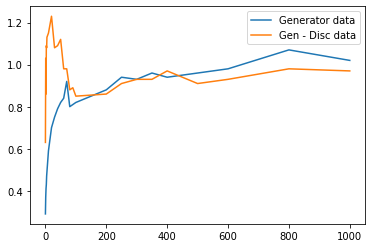

In [14]:
look_aheads = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 250, 300, 350, 400, 500, 600, 800, 1000]
# look_aheads = [0, 5]
performance = []
for look_ahead in look_aheads:
    res = [look_ahead]
    scaler, dataset = load_data()
    # split into train and test sets
    # use k-fold later to split
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    #     print(len(train), len(test))
    look_back = 1
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)
    #     print(testX)
    #     print(testY)
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    model = make_model()
    
    print(look_ahead)
    trainPredict, gen_testPredict, testY, trainY = fit_generator(model, trainX, trainY, testY)
    testScore = gen_results(trainY, testY, trainPredict, gen_testPredict)
    testScore = round(testScore, 2)
    res.append(testScore)

    dataset,trainX, trainY, testY = init_discriminator(dataset, trainX, trainY, testY)
    disc_model = make_model()
    disc_testPredict, trainPredict, testY, trainY = fit_discriminator(disc_model, trainX, testX, trainY, testY)
    finalScore = final_result(gen_testPredict, disc_testPredict)
    finalScore = round(finalScore, 2)

    res.append(finalScore)
    performance.append(res)
    
print(performance)

data = numpy.array(performance)
df = pandas.DataFrame(data,
                 columns=['look_ahead', 'generator', 'generator - discriminator'])
look_ahead_data= df['look_ahead']
generator_data = df['generator']
gen_disc_data = df['generator - discriminator']
plt.plot(look_ahead_data, generator_data, label='Generator data')
plt.plot(look_ahead_data, gen_disc_data, label='Gen - Disc data')
plt.legend()
plt.show()


In [13]:
res = [
        [0, 0.28, 0.74], [1, 0.36, 0.98], [2, 0.43, 0.83], [3, 0.43, 1.04], [4, 0.48, 1.08], [5, 0.49, 1.0],
        [6, 0.51, 1.1],[7, 0.58, 1.31], [8, 0.56, 1.07], [9, 0.59, 1.16], [10, 0.59, 1.12], [20, 0.69, 1.22],
        [30, 0.77, 1.24], [40, 0.78, 1.14], [50, 0.83, 1.21], [60, 0.95, 1.03], [70, 0.88, 1.08], [80, 0.82, 0.9],
        [90, 0.86, 1.09], [100, 0.86, 0.97], [150, 0.87, 0.88], [200, 0.89, 0.87], [250, 0.93, 0.9], [300, 0.97, 0.95],
        [400, 0.94, 0.93], [500, 0.93, 0.9], [600, 1.11, 1.02], [700, 1.07, 1.0], [800, 1.02, 0.94]
    ]